In [1]:
import statsmodels.stats.power as power
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import binom, multinomial
from scipy.special import comb


In [2]:
# Solving a problem with different solvers.
x = cp.Variable(2)
obj = cp.Minimize(x[0] + cp.norm(x, 1))
constraints = [x >= 2]
prob = cp.Problem(obj, constraints)

# Solve with MOSEK.
prob.solve(solver=cp.MOSEK)
print("optimal value with MOSEK:", prob.value)

SolverError: The solver MOSEK is not installed.

In [2]:
# The idea here is that the disease variant may not be in LD with any marker variants

1.6785596330648533 0.020000949475195103
P[D|novar]= 0.001212038887734371
2.400795880739394 0.020000983496513518
P[D|novar]= 0.008149694425778859
2.973683843741486 0.02000097228253407
P[D|novar]= 0.011424263735570426
4.200683745297919 0.020000997993486043
P[D|novar]= 0.014764082562254172
8.032269501384325 0.020000993760368298
P[D|novar]= 0.017703431948743797
2.000966899050048 0.020000991517848284
P[D|novar]= 0.017952085672850036
2.400795880739394 0.020000983496513518
P[D|novar]= 0.008149694425778859
3.3644853225373894 0.01999901127691299
P[D|novar]= 0.0011943350477026723
2.7703961978750025 0.010000994057655128
P[D|novar]= 0.00390808366676406
1.4613308207492954 0.10000089913621352
P[D|novar]= 0.05104461931753674
0.1650207162122932 0.5000009470480704
P[D|novar]= 0.4182305420451755
2.400795880739394 0.020000983496513518
P[D|novar]= 0.008149694425778859
3.944000668309805 0.02000099240337182
P[D|novar]= 0.0003750780257371633
5.623765344087589 0.019999008713628013
P[D|novar]= 1.30392863914328

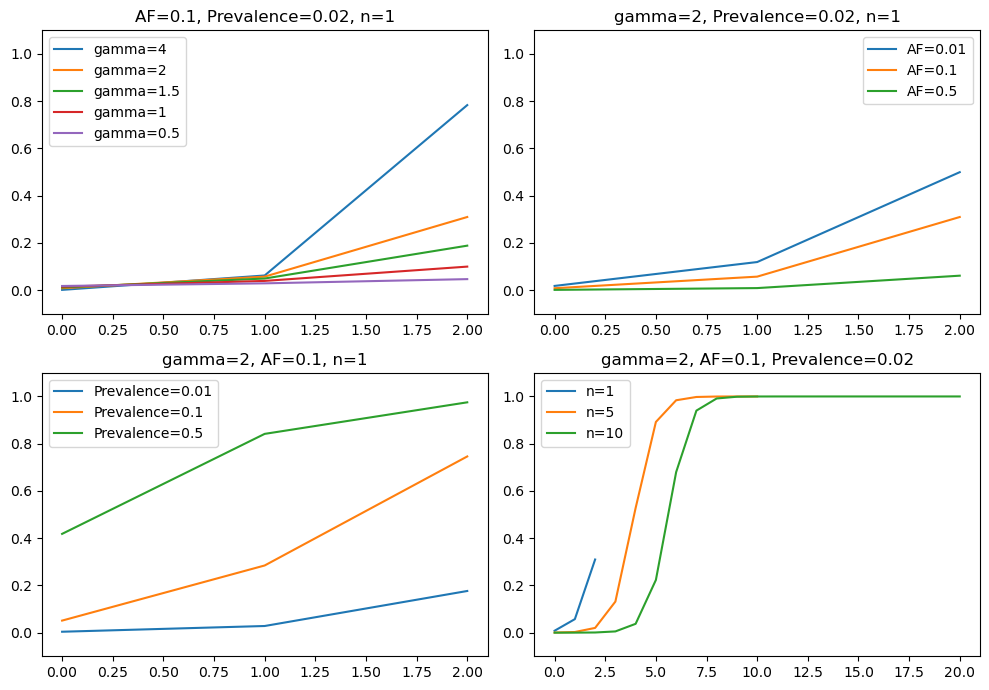

In [84]:
# Genetic Relative Risk

# if you have one of the rare variants, your chance of getting D is gamma-times more than usual
# this doesn't work as we consider multiple variants (and actually doesn't work in the original case if cgamma^2>1)


class P_D_givG():
    def __init__(self, gamma, prevalence, af):
        self.gamma = gamma
        self.p = prevalence
        self.a = af
        self.x = np.arange(3)
        
        # chose c to get desired overall disease prevalence
        var_p = binom.pmf(self.x, 2*self.n, self.a)
        self.x_0 = 0
        rr = self()
        while np.abs(np.sum(var_p*rr)-self.p)>10**-6:
        #for _ in range(10):
            f_x = np.sum(var_p*rr)-self.p
            f_prime_x = f_x-1
            #f_prime_x = np.sum(-self.gamma*var_p*np.exp(-self.gamma*np.clip(self.x-self.x_0, 0.01, None)))
            self.x_0 = self.x_0 - f_x/f_prime_x
            rr = self()
        print(self.x_0, np.sum(var_p*rr))
        print('P[D|novar]=', self()[0])
        
    def __call__(self):
        return 1/(1+np.exp(-self.gamma*(self.x-self.x_0)))
        #return 1-np.exp(-self.gamma*(np.clip(self.x-self.x_0, 0.01, None)))

gamma, n, p = 2, 1, 0.02

plt.figure(figsize=(10, 7))
plt.subplot(2, 2, 1)
plt.plot(np.arange(2*n+1), P_D_givG(4, n, p, 0.1)(), label='gamma=4')
plt.plot(np.arange(2*n+1), P_D_givG(2, n, p, 0.1)(), label='gamma=2')
plt.plot(np.arange(2*n+1), P_D_givG(1.5, n, p, 0.1)(), label='gamma=1.5')
plt.plot(np.arange(2*n+1), P_D_givG(1, n, p, 0.1)(), label='gamma=1')
plt.plot(np.arange(2*n+1), P_D_givG(0.5, n, p, 0.1)(), label='gamma=0.5')
plt.title('AF=0.1, Prevalence=0.02, n=1')
plt.ylim([-0.1, 1.1])
plt.legend()

plt.subplot(2, 2, 2)
plt.plot(np.arange(2*n+1), P_D_givG(gamma, n, p, 0.01)(), label='AF=0.01')
plt.plot(np.arange(2*n+1), P_D_givG(gamma, n, p, 0.1)(), label='AF=0.1')
plt.plot(np.arange(2*n+1), P_D_givG(gamma, n, p, 0.5)(), label='AF=0.5')
plt.ylim([-0.1, 1.1])
plt.title('gamma=2, Prevalence=0.02, n=1')
plt.legend()

plt.subplot(2, 2, 3)
plt.plot(np.arange(2*n+1), P_D_givG(gamma, n, 0.01, 0.1)(), label='Prevalence=0.01')
plt.plot(np.arange(2*n+1), P_D_givG(gamma, n, 0.1, 0.1)(), label='Prevalence=0.1')
plt.plot(np.arange(2*n+1), P_D_givG(gamma, n, 0.5, 0.1)(), label='Prevalence=0.5')
plt.ylim([-0.1, 1.1])
plt.title('gamma=2, AF=0.1, n=1')
plt.legend()

plt.subplot(2, 2, 4)
plt.plot(np.arange(2*1+1), P_D_givG(gamma, 1, p, 0.1)(), label='n=1')
plt.plot(np.arange(2*5+1), P_D_givG(gamma, 5, p, 0.1)(), label='n=5')
plt.plot(np.arange(2*10+1), P_D_givG(gamma, 10, p, 0.1)(), label='n=10')
plt.ylim([-0.1, 1.1])
plt.title('gamma=2, AF=0.1, Prevalence=0.02')
plt.legend()

plt.tight_layout()

plt.show()

In [113]:
# Power for association test
def get_samples_assoc(p_d):
    a = p_d.a
    n = p_d.n
    p = p_d.p
    gamma = p_d.gamma
    
    tind_power = power.TTestIndPower()
    
    # What's the probability of having variants at other sites?
    var_p = binom.pmf(np.arange(2*(n-1)+1), 2*(n-1), a)
    
    rr = p_d()
    #print('rr', rr)
    
    # now we want P[G_this_site=x|D] = P[D|G=x]*P[G=x]/P[D]
    p_g2_givD = np.sum(var_p*rr[2:])*a**2/p
    p_g1_givD = np.sum(var_p*rr[1:-1])*2*a*(1-a)/p
    p_g0_givD = np.sum(var_p*rr[:-2])*(1-a)**2/p
    print('p_givD', p_g0_givD, p_g1_givD, p_g2_givD)
    
    # and P[G_this_site=x|~D] = P[~D|G=x]*P[G=x]/P[~D]
    p_g2_givnoD = (1-np.sum(var_p*rr[2:]))*a**2/(1-p)
    p_g1_givnoD = (1-np.sum(var_p*rr[1:-1]))*2*a*(1-a)/(1-p)
    p_g0_givnoD = (1-np.sum(var_p*rr[:-2]))*(1-a)**2/(1-p)
    print('p_givnoD', p_g0_givnoD, p_g1_givnoD, p_g2_givnoD)

    m1 = 2*p_g2_givD + p_g1_givD # E[G|D]
    m2 = 2*p_g2_givnoD + p_g1_givnoD # E[G|~D]
    std1 = np.sqrt(p_g2_givD*(2-m1)**2 + p_g1_givD*(1-m1)**2) + p_g0_givD*m1**2
    std2 = np.sqrt(p_g2_givnoD*(2-m2)**2 + p_g1_givnoD*(1-m2)**2 + p_g0_givnoD*m2**2)
    print(m1, m2, std1, std2)
    return tind_power.solve_power(abs(m1-m2)/max(std1, std2), nobs1=None, alpha=0.05, power=0.9, ratio=1)




In [129]:


# Power for sibpair test
def get_samples_sibpair_concordant(p_d):
    a = p_d.a
    n = p_d.n
    p = p_d.p
    
    options = np.zeros(((2*(n-1)+1)**3, 4), dtype=int)
    options[:, 0] = np.repeat(np.arange(2*(n-1)+1), (2*(n-1)+1)**2)
    options[:, 1] = np.tile(np.repeat(np.arange(2*(n-1)+1), (2*(n-1)+1)), 2*(n-1)+1)
    options[:, 2] = np.tile(np.arange(2*(n-1)+1), (2*(n-1)+1)**2)
    options[:, 3] = 2*(n-1) - np.sum(options, axis=1)
    options = options[options[:, -1]>=0, :]
    print(options.shape)
    
    t_power = power.TTestPower()

    # What's the probability of having variants at other sites?
    var_p = multinomial.pmf(options, n=2*(n-1), p=[a**2+0.5*a*(1-a), # both children inherit a variant (either parent has 2 or parent has 1 and both children inherit it)
                                      0.5*a*(1-a), # child1 inherits a variant, but not child2
                                      0.5*a*(1-a), # child2 inherits a variant, but not child1
                                      0.5*a*(1-a) + (1-a)**2]) # neither children inherit a variant (either parent has 0 or parent has 1 and neither child inherits it)
    if n==1:
        var_p = np.array([1])
        
    rr = p_d()

    vars_sib1 = options[:, 0]+options[:, 1]
    vars_sib2 = options[:, 0]+options[:, 2]
        
    # P[D=2|IBD=2]
    p_D2_givIBD2 = np.sum(a**2*var_p*rr[vars_sib1+2]*rr[vars_sib2+2]) + \
                   np.sum(2*a*(1-a)*var_p*rr[vars_sib1+1]*rr[vars_sib2+1]) + \
                   np.sum((1-a)**2*var_p*rr[vars_sib1]*rr[vars_sib2])
        
    # P[D=2|IBD=1]
    p_D2_givIBD1 = np.sum(a**3*var_p*rr[vars_sib1+2]*rr[vars_sib2+2]) + \
                   np.sum(a**2*(1-a)*var_p*rr[vars_sib1+2]*rr[vars_sib2+1]) + \
                   np.sum(a**2*(1-a)*var_p*rr[vars_sib1+1]*rr[vars_sib2+2]) + \
                   np.sum(a*(1-a)**2*var_p*rr[vars_sib1+1]*rr[vars_sib2+1]) + \
                   np.sum((1-a)*a**2*var_p*rr[vars_sib1+1]*rr[vars_sib2+1]) + \
                   np.sum((1-a)**2*a*var_p*rr[vars_sib1+1]*rr[vars_sib2]) + \
                   np.sum((1-a)**2*a*var_p*rr[vars_sib1]*rr[vars_sib2+1]) + \
                   np.sum((1-a)**3*var_p*rr[vars_sib1]*rr[vars_sib2])
    
    # P[D=2|IBD=0]
    p_D2_givIBD0 = np.sum(a**4*var_p*rr[vars_sib1+2]*rr[vars_sib2+2]) + \
                   np.sum(2*a**3*(1-a)*var_p*rr[vars_sib1+2]*rr[vars_sib2+1]) + \
                   np.sum(2*a**3*(1-a)*var_p*rr[vars_sib1+1]*rr[vars_sib2+2]) + \
                   np.sum(4*a**2*(1-a)**2*var_p*rr[vars_sib1+1]*rr[vars_sib2+1]) + \
                   np.sum(a**2*(1-a)**2*var_p*rr[vars_sib1+2]*rr[vars_sib2]) + \
                   np.sum(a**2*(1-a)**2*var_p*rr[vars_sib1]*rr[vars_sib2+2]) + \
                   np.sum(2*a*(1-a)**3*var_p*rr[vars_sib1+1]*rr[vars_sib2]) + \
                   np.sum(2*a*(1-a)**3*var_p*rr[vars_sib1]*rr[vars_sib2+1]) + \
                   np.sum((1-a)**4*var_p*rr[vars_sib1]*rr[vars_sib2])
            
    p_D2 = p_D2_givIBD2*0.25 + p_D2_givIBD1*0.5 + p_D2_givIBD0*0.25
    print('prob of aff-aff sibpair', p_D2, p**2)

    p_IBD2_givD2 = p_D2_givIBD2*0.25/p_D2
    p_IBD1_givD2 = p_D2_givIBD1*0.5/p_D2
    p_IBD0_givD2 = p_D2_givIBD0*0.25/p_D2
    
    print(p_IBD2_givD2, p_IBD1_givD2, p_IBD0_givD2)
    
    m = 2*p_IBD2_givD2 + p_IBD1_givD2
    std = np.sqrt(p_IBD2_givD2*(2-m)**2 + p_IBD1_givD2*(1-m)**2 + p_IBD0_givD2*m**2)
    print('m', m, std, np.sqrt(0.5))

    return t_power.solve_power(abs(m-1)/np.sqrt(0.5), nobs=None, alpha=0.05, power=0.9)


In [130]:


# Power for sibpair test
def get_samples_sibpair_discordant(p_d):
    a = p_d.a
    n = p_d.n
    p = p_d.p
    gamma = p_d.gamma
    
    options = np.zeros(((2*(n-1)+1)**3, 4), dtype=int)
    options[:, 0] = np.repeat(np.arange(2*(n-1)+1), (2*(n-1)+1)**2)
    options[:, 1] = np.tile(np.repeat(np.arange(2*(n-1)+1), (2*(n-1)+1)), 2*(n-1)+1)
    options[:, 2] = np.tile(np.arange(2*(n-1)+1), (2*(n-1)+1)**2)
    options[:, 3] = 2*(n-1) - np.sum(options, axis=1)
    options = options[options[:, -1]>=0, :]
    print(options.shape)
    
    t_power = power.TTestPower()

    # What's the probability of having variants at other sites?
    var_p = multinomial.pmf(options, n=2*(n-1), p=[a**2+0.5*a*(1-a), # both children inherit a variant (either parent has 2 or parent has 1 and both children inherit it)
                                      0.5*a*(1-a), # child1 inherits a variant, but not child2
                                      0.5*a*(1-a), # child2 inherits a variant, but not child1
                                      0.5*a*(1-a) + (1-a)**2]) # neither children inherit a variant (either parent has 0 or parent has 1 and neither child inherits it)
    if n==1:
        var_p = np.array([1])
        
    rr = p_d()

    vars_sib1 = options[:, 0]+options[:, 1]
    vars_sib2 = options[:, 0]+options[:, 2]
        
    # P[D=1|IBD=2]
    p_D1_givIBD2 = np.sum(a**2*var_p*rr[vars_sib1+2]*(1-rr[vars_sib2+2])) + \
                   np.sum(2*a*(1-a)*var_p*rr[vars_sib1+1]*(1-rr[vars_sib2+1])) + \
                   np.sum((1-a)**2*var_p*rr[vars_sib1]*(1-rr[vars_sib2]))
        
    # P[D=1|IBD=1]
    p_D1_givIBD1 = np.sum(a**3*var_p*rr[vars_sib1+2]*(1-rr[vars_sib2+2])) + \
                   np.sum(a**2*(1-a)*var_p*rr[vars_sib1+2]*(1-rr[vars_sib2+1])) + \
                   np.sum(a**2*(1-a)*var_p*rr[vars_sib1+1]*(1-rr[vars_sib2+2])) + \
                   np.sum(a*(1-a)**2*var_p*rr[vars_sib1+1]*(1-rr[vars_sib2+1])) + \
                   np.sum((1-a)*a**2*var_p*rr[vars_sib1+1]*(1-rr[vars_sib2+1])) + \
                   np.sum((1-a)**2*a*var_p*rr[vars_sib1+1]*(1-rr[vars_sib2])) + \
                   np.sum((1-a)**2*a*var_p*rr[vars_sib1]*(1-rr[vars_sib2+1])) + \
                   np.sum((1-a)**3*var_p*rr[vars_sib1]*(1-rr[vars_sib2]))
    
    # P[D=1|IBD=0]
    p_D1_givIBD0 = np.sum(a**4*var_p*rr[vars_sib1+2]*(1-rr[vars_sib2+2])) + \
                   np.sum(2*a**3*(1-a)*var_p*rr[vars_sib1+2]*(1-rr[vars_sib2+1])) + \
                   np.sum(2*a**3*(1-a)*var_p*rr[vars_sib1+1]*(1-rr[vars_sib2+2])) + \
                   np.sum(4*a**2*(1-a)**2*var_p*rr[vars_sib1+1]*(1-rr[vars_sib2+1])) + \
                   np.sum(a**2*(1-a)**2*var_p*rr[vars_sib1+2]*(1-rr[vars_sib2])) + \
                   np.sum(a**2*(1-a)**2*var_p*rr[vars_sib1]*(1-rr[vars_sib2+2])) + \
                   np.sum(2*a*(1-a)**3*var_p*rr[vars_sib1+1]*(1-rr[vars_sib2])) + \
                   np.sum(2*a*(1-a)**3*var_p*rr[vars_sib1]*(1-rr[vars_sib2+1])) + \
                   np.sum((1-a)**4*var_p*rr[vars_sib1]*(1-rr[vars_sib2]))
            
    p_D1 = p_D1_givIBD2*0.25 + p_D1_givIBD1*0.5 + p_D1_givIBD0*0.25
    print('prob of aff-unaff sibpair', p_D1, p*(1-p))

    p_IBD2_givD1 = p_D1_givIBD2*0.25/p_D1
    p_IBD1_givD1 = p_D1_givIBD1*0.5/p_D1
    p_IBD0_givD1 = p_D1_givIBD0*0.25/p_D1
    
    m = 2*p_IBD2_givD1 + p_IBD1_givD1
    std = np.sqrt(p_IBD2_givD1*(2-m)**2 + p_IBD1_givD1*(1-m)**2 + p_IBD0_givD1*m**2)
    print('m', m, std, np.sqrt(0.5))

    return t_power.solve_power(abs(m-1)/np.sqrt(0.5), nobs=None, alpha=0.05, power=0.9)


In [131]:
n = 10
gamma = 5 # GRR
p = 0.2 # disease prevalence

bins_a = np.hstack((10.0**np.arange(-5, 0, 0.5), [0.5]))

samples_assoc = np.zeros((len(bins_a),))
samples_sibpair_con = np.zeros((len(bins_a),))
samples_sibpair_dis = np.zeros((len(bins_a),))

for i in range(len(bins_a)):
    print('AF', bins_a[i])
    p_d = P_D(gamma, n, p, bins_a[i])
    samples_assoc[i] = get_samples_assoc(p_d)
    samples_sibpair_con[i] = get_samples_sibpair_concordant(p_d)
    samples_sibpair_dis[i] = get_samples_sibpair_discordant(p_d)


AF 1e-05
0.2774527066836895 0.19999974046810673
P[D|novar]= 0.19984497751741395
p_givD 0.9999013292680544 9.737257257014946e-05 4.999091448605746e-10
p_givnoD 0.9999996678079865 6.566068574626358e-07 2.2713784856381872e-14
9.737357238843918e-05 6.566069028902055e-07 0.009866904124118983 0.0008103126046071912
(1330, 4)
prob of aff-aff sibpair 0.040059766178495625 0.04000000000000001
0.2500373646628785 0.4999999998255595 0.24996263551156203
m 1.0000747291513166 0.707106777361096 0.7071067811865476
(1330, 4)
prob of aff-unaff sibpair 0.15993997428961032 0.16000000000000003
m 0.9999812827759805 0.707106780907929 0.7071067811865476
AF 3.1622776601683795e-05
0.27787163155240857 0.19999972711011182
P[D|novar]= 0.19951024307504847
p_givD 0.999690731838844 0.00030789871262516485 4.999089895794095e-09
p_givnoD 0.9999982613487846 2.0797633479182596e-06 2.275260514764121e-13
0.0003079087108049564 2.0797638029703624e-06 0.01754230452033102 0.0014421372793900259
(1330, 4)
prob of aff-aff sibpair 0.0

[1.00000000e-05 3.16227766e-05 1.00000000e-04 3.16227766e-04
 1.00000000e-03 3.16227766e-03 1.00000000e-02 3.16227766e-02
 1.00000000e-01 3.16227766e-01 5.00000000e-01]


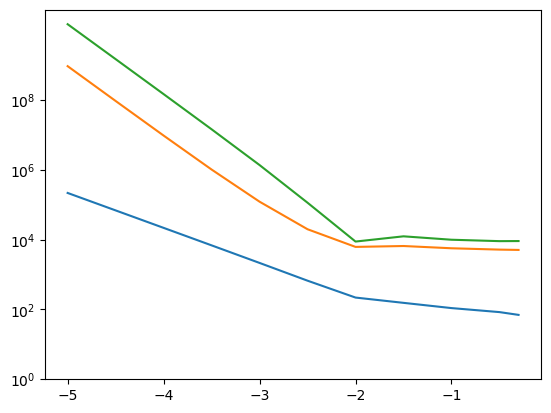

In [125]:
print(bins_a)
plt.plot(np.log10(bins_a), np.log10(samples_assoc))
plt.plot(np.log10(bins_a), np.log10(samples_sibpair_con))
plt.plot(np.log10(bins_a), np.log10(samples_sibpair_dis))
#plt.xticks(np.arange(-5, 0), ['$10^{%d}$' % i for i in np.arange(-5, 0)])
plt.yticks(np.arange(0, 10, 2), ['$10^{%d}$' % i for i in np.arange(0, 10, 2)])
plt.show()

In [118]:
print(samples_sibpair_con)

[2.36113135e+08 2.69547825e+07 3.85231714e+06 8.38064421e+05
 3.08782023e+05 1.70611852e+05 1.19276587e+05 9.73158510e+04
 8.72227214e+04 8.20959176e+04 8.05626084e+04]


In [112]:
print(samples_assoc)

[29306.20900799  9457.41744348  3177.71254639  1184.1494861
   545.53310953   346.84455358   297.12458597   298.92546899
   315.92098027   338.34741221   351.63065164]


In [119]:
print(samples_assoc)

[215559.61106889  68888.18592006  22484.31285602   7751.90840451
   3002.24063813   1409.21243144    818.86075356    565.28533803
    451.27832551    414.09074365    378.51954322]
